## 1. 라이브러리

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2
from tqdm import tqdm
from PIL import Image
import pickle

## 2. 메타데이터 불러오기

In [2]:
dpath = 'data/' # 데이터 경로 설정
data = pd.read_csv(dpath + 'metadata.csv')
data

,album_id,album_name,artist,album_release_date,album_total_tracks,emotion,playlist_name
0,0025Y5D7IOZVpEfQtpvHIi,Into the Surf,Foals,2019-09-25,3,relaxed,calm winter morning ☆☆
1,002hMu6uJDan1XKVp3pmnb,Becoming,Feather,2021-01-13,5,sad,Sad Beats
2,002mOl8os2F1mDYRz8qU2a,Антигерой,ELMAN,2019-06-06,1,sad,슬픔
3,004EYz2DQttcGvyTQGDmLp,Merry Christmas Baby / White Christmas,Otis Redding,1968,2,happy,Happy Holidays
4,005KGm28jIUE3hW019Itx6,Too Much Love,Mujo,2021-04-15,1,relaxed,"Chill Beats 💙 groove, relax"
...,...,...,...,...,...,...,...
63309,7zw73YMhMg7lnMrkUAzE8t,Just Another Memory,JustSidekicks,2020-07-10,1,happy,Happy Vibes ?��
63310,7zwLfr8xSz9rWPU5KNBHkQ,cherry,Oatmello,2019-05-24,1,relaxed,Relax Lofi 😴
63311,7zxLuEY7mKLKdyWjnCfP35,Colorblind (feat. Dayseeker),Adventure Club,2021-08-13,1,sad,Sad Beats
63312,7zxfQk44mX0eW4eWtdDlKI,Mind Right,TK N Cash,2014-10-14,1,angry,Pissed Off Workout


## 객체기반 추천시스템 프로세스
**객체기반 필터링 - 1단계**

객체가 인식되지 않은 경우부터 여러개 인식된 경우까지 다양하므로, 인식된 객체의 종류와 개수로 1차 필터링한다

1. 어떤 객체가 몇 개 인식되었는지 나타내는 벡터 생성 (index=객체의클래스아이디, value=해당객체의수)
2. 객체의 아이디와 해당 객체의 수가 같은 이미지만 남김 (벡터가 정확히 일치하는 이미지만)

**객체기반 필터링 - 2단계**

이제 1차 필터링을 거친 인덱스들에 대해 처음에 생성했던 객체정보를 담은 리스트(obj_list)로 거리를 계산하여 ranking

## 3-1. 사전에 수집된 이미지의 인덱스를 입력받아 추천하는 시스템 

YOLO 객체인식 참고: https://hanryang1125.tistory.com/9

In [3]:
classes = ["person", "bicycle", "car", "motorcycle",
           "airplane", "bus", "train", "truck", "boat", "traffic light", "fire hydrant",
           "stop sign", "parking meter", "bench", "bird", "cat", "dog", "horse",
           "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "backpack",
           "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis",
           "snowboard", "sports ball", "kite", "baseball bat", "baseball glove", "skateboard",
           "surfboard", "tennis racket", "bottle", "wine glass", "cup", "fork", "knife",
           "spoon", "bowl", "banana", "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog",
           "pizza", "donut", "cake", "chair", "couch", "potted plant", "bed", "dining table",
           "toilet", "tv", "laptop", "mouse", "remote", "keyboard",
           "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
           "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

In [9]:
# input index와 감정을 입력받아 n개의 추천 이미지 인덱스를 반환하는 함수
def recommend_by_idx(input_idx, sentiment='happy', n=5):
    
    # 이미지 불러오기
    image_list = []
    image_array_list = []
    na_id = []
    album_ids = data[data['emotion'] == sentiment]['album_id']
    
    for album_id in tqdm(album_ids):
        image_list.append(Image.open(dpath + "emotion_album_images/{}/{}.jpg".format(sentiment, album_id)).resize((300,300)))
        image_array_list.append(np.array(image_list[-1]))

        
    # 미리 수집된 객체인식 정보 리스트 불러오기
    with open('{}_obj_list.pickle'.format(sentiment), 'rb') as f:
        obj_list = pickle.load(f)
    
    # first_vec: 이미지마다 어떤 객체가 몇 개 인식되었는지에 대한 벡터를 담고있는 리스트
    first_vec = []

    for item in obj_list:
        class_ids = pd.DataFrame(item)[0]  # 관심있는 클래스아이디만 추출
        temp_vec = np.zeros((len(classes) + 1))  # 제로벡터 생성

        # 클래스아이디를 카운트한 뒤, temp_vec에 개수를 저장
        cnt = class_ids.value_counts() 
        for r in range(len(cnt)):
            idx = cnt.index[r]
            temp_vec[idx + 1] = cnt.loc[idx]  
            # index 0에는 클래스아이디가 -1인 경우(인식된 객체가 없는 경우)를 담기 위해 (클래스아이디+1)의 인덱스부터 개수를 저장함

        first_vec.append(temp_vec)
    

    # 1차 필터링: 인식된 객체와 그 수가 같은 이미지만 필터링
    my_image = first_vec[input_idx]
    indices = []

    for i in range(len(first_vec)):
        if sum(first_vec[i] == my_image) == len(my_image):
            indices.append(i)

    print("input 이미지의 객체인식 벡터 = ", my_image)
    print("1차 필터링 완료 -> {}개".format(len(indices))) 

    my_list = sum(obj_list[input_idx], [])     # 객체정보를 담은 중첩리스트를 flatten
    compare_index, compare_list = [], []       # 비교할 이미지의 인덱스, 비교할 이미지의 객체정보 리스트

    for i in range(len(obj_list)):
        if i in indices:  # 1차 필터링을 통과한 인덱스들만 추출
            temp = sum(obj_list[i], [])  #flatten
            compare_index.append(i)
            compare_list.append(temp)


    # 객체 정보(클래스아이디, 신뢰도, x, y, w, h)를 기준으로 유클리디안 거리 계산
    final_dist = []
    for vec in compare_list:
        euc_dist = np.linalg.norm(np.array(vec) - np.array(my_list))
        final_dist.append(euc_dist)
    
    # 거리가 0인 것은 같은 앨범임을 뜻하므로 nan 값으로 제거
    final_dist = [np.nan if dist == 0 else dist for dist in final_dist]

    # 2차 필터링: 거리가 짧은(유사도가 높은) 최종 추천앨범 인덱스 n개를 추출
    final_idx = []
    for i in np.argsort(final_dist)[:n]:
        final_idx.append(compare_index[i])

        
    # 상위 8개의 이미지 확인
    plt.figure(figsize=(18,4))
    plt.subplot(2, n, 1)
    plt.imshow(image_list[input_idx])
    plt.axis('off')

    for i, idx in enumerate(final_idx):
        plt.subplot(2, n, i+n+1)
        plt.imshow(image_list[idx])
        plt.axis('off')
    plt.show()
    
    # 추천된 앨범의 정보 출력
    for i, idx in enumerate(final_idx):
        print("{}. 유사도: {}\t앨범이름: {}".format(i,
                                             round(np.sort(final_dist)[i], 2),
                                             data[data['album_id'] == album_ids.iloc[idx]]['album_name'].values[0]))
    
    return final_idx

**결과 (다양한 객체에 대해 결과확인)**

100%|████████████████████████████████████████████████████████████████████████████| 15403/15403 [03:24<00:00, 75.26it/s]


input 이미지의 객체인식 벡터 =  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1차 필터링 완료 -> 5578개


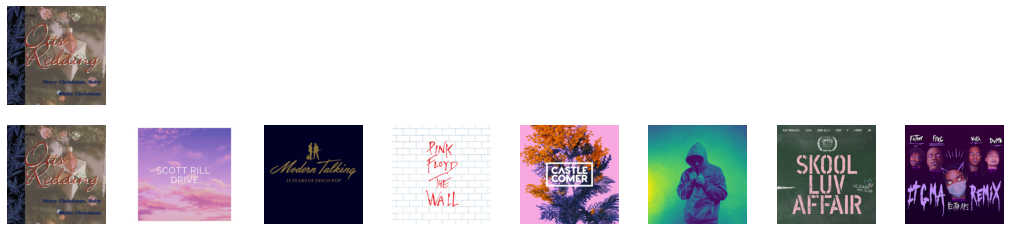

0. 유사도: nan	앨범이름: Merry Christmas Baby / White Christmas
1. 유사도: nan	앨범이름: Drive
2. 유사도: nan	앨범이름: 25 Years Of Disco-Pop
3. 유사도: nan	앨범이름: The Wall
4. 유사도: nan	앨범이름: Castlecomer
5. 유사도: nan	앨범이름: DEMO
6. 유사도: nan	앨범이름: Skool Luv Affair
7. 유사도: nan	앨범이름: IT G MA REMIX (feat. A$AP Ferg, Father, Dumbfoundead, Waka Flocka Flame)


[0, 10224, 10221, 10219, 10210, 10208, 10202, 10199]

In [5]:
# 인식된 객체가 없는 경우 -> 유사도가 모두 nan이 됨 (x,y,신뢰도 등이 존재하지 않으므로)
SENT = 'happy'
INPUT = 0

recommend_by_idx(input_idx = INPUT, sentiment = SENT, n = 8)

100%|████████████████████████████████████████████████████████████████████████████| 15403/15403 [03:22<00:00, 75.92it/s]


input 이미지의 객체인식 벡터 =  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1차 필터링 완료 -> 40개


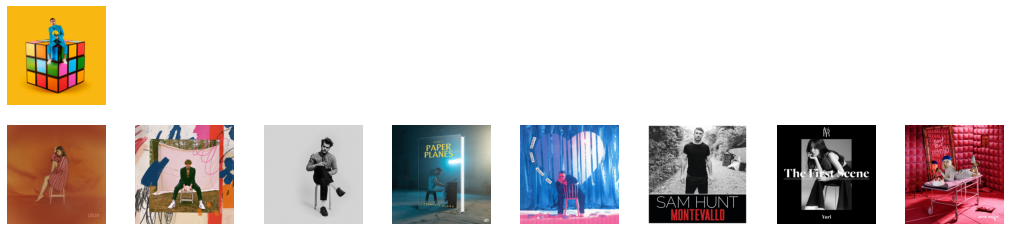

0. 유사도: 110.49	앨범이름: LÉON
1. 유사도: 128.88	앨범이름: Lost
2. 유사도: 133.45	앨범이름: I Spy EP
3. 유사도: 135.11	앨범이름: Paper Planes
4. 유사도: 136.29	앨범이름: Hopeless Romantic
5. 유사도: 143.16	앨범이름: Montevallo
6. 유사도: 155.78	앨범이름: The First Scene - The 1st Mini Album
7. 유사도: 165.22	앨범이름: Sweet but Psycho


[9473, 11749, 10883, 2972, 1701, 980, 3768, 14271]

In [6]:
# 사람 1, 의자 1
SENT = 'happy'
INPUT = 100

recommend_by_idx(input_idx = INPUT, sentiment = SENT, n = 8)

100%|████████████████████████████████████████████████████████████████████████████| 15403/15403 [03:40<00:00, 69.71it/s]


input 이미지의 객체인식 벡터 =  [0. 5. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1차 필터링 완료 -> 219개


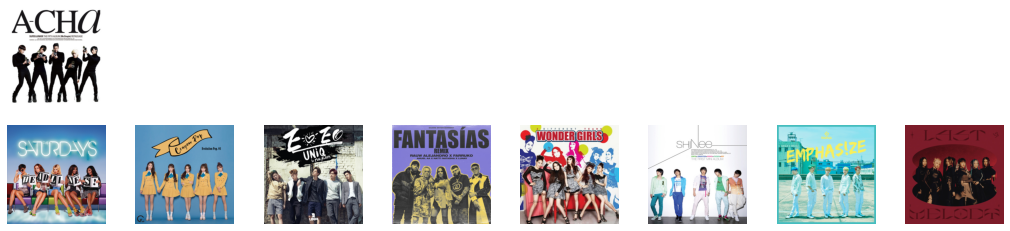

0. 유사도: 58.01	앨범이름: Headlines
1. 유사도: 64.56	앨범이름: Evolution Pop_Vol. 1
2. 유사도: 71.48	앨범이름: The 1st Mini Album 'EOEO'
3. 유사도: 76.66	앨범이름: Fantasias (Remix) [feat. Farruko & Lunay]
4. 유사도: 77.14	앨범이름: 2 Different Tears
5. 유사도: 79.69	앨범이름: Replay - The First Mini Album
6. 유사도: 87.73	앨범이름: emphas!ze
7. 유사도: 90.17	앨범이름: Last Melody


[10395, 8944, 14242, 5358, 2888, 5877, 6224, 8901]

In [7]:
# 사람 5
SENT = 'happy'
INPUT = 4817

recommend_by_idx(input_idx = INPUT, sentiment = SENT, n = 8)

100%|████████████████████████████████████████████████████████████████████████████| 15403/15403 [04:40<00:00, 54.83it/s]


input 이미지의 객체인식 벡터 =  [ 0. 10.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  7.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  1.  0.  0.  0.  0.  0.]
1차 필터링 완료 -> 1개


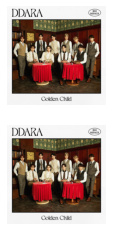

0. 유사도: nan	앨범이름: DDARA


[15274]

In [10]:
# 사람 10 + 다른 객체 여럿이 인식되어 복잡한 이미지는 완전히 같은 객체들이 인식된 이미지가 없음
SENT = 'happy'
INPUT = 15274

recommend_by_idx(input_idx = INPUT, sentiment = SENT, n = 8)

100%|████████████████████████████████████████████████████████████████████████████| 13206/13206 [04:34<00:00, 48.15it/s]


input 이미지의 객체인식 벡터 =  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1차 필터링 완료 -> 4046개


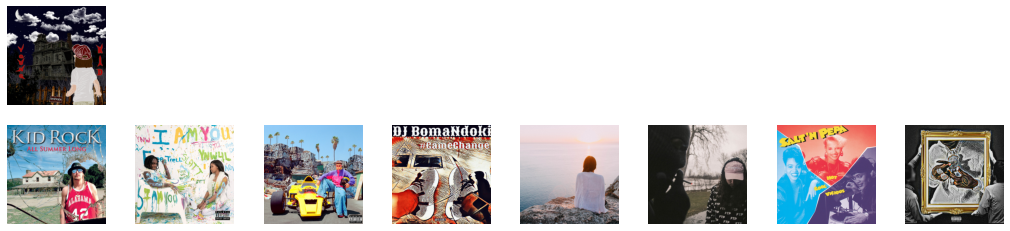

0. 유사도: 15.69	앨범이름: All Summer Long
1. 유사도: 15.72	앨범이름: I AM YOU
2. 유사도: 19.82	앨범이름: Do You Feel Me?
3. 유사도: 26.74	앨범이름: #GameChange (Gangs)
4. 유사도: 31.15	앨범이름: Frenetic
5. 유사도: 40.62	앨범이름: Songsthatwewontgetsuedforbutattheendofthedayweallgonnadieanyway
6. 유사도: 40.83	앨범이름: Hot, Cool & Vicious
7. 유사도: 41.46	앨범이름: Masterpiece


[5843, 12897, 11086, 7816, 1343, 3103, 9220, 11494]

In [11]:
# 사람 1
SENT = 'angry'
INPUT = 555

recommend_by_idx(input_idx = INPUT, sentiment = SENT, n = 8)

## 3-2. 기존에 없던 새로운 이미지를 입력받아 추천하는 함수 구현

In [12]:
# YOLO 객체 인식 후 인식된 객체 정보를 반환하는 함수
def yolo_trans(frame, size, score_threshold, nms_threshold):
    
    # YOLO 네트워크 불러오기
    net = cv2.dnn.readNet(f"yolov4.weights", "yolov4.cfg")
    layer_names = net.getLayerNames()
    output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

    # 이미지의 높이, 너비, 채널 받아오기
    height, width, channels = frame.shape

    # 네트워크에 넣기 위한 전처리
    blob = cv2.dnn.blobFromImage(frame, 0.00392, (size, size), (0, 0, 0), True, crop=False)

    # 전처리된 blob 네트워크에 입력
    net.setInput(blob)

    # 결과 받아오기
    try:
        outs = net.forward(output_layers)
    except:
        return []

    # 각각의 데이터를 저장할 빈 리스트
    class_ids = []
    confidences = []
    boxes = []

    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]

            if confidence > 0.1:
                # 탐지된 객체의 너비, 높이 및 중앙 좌표값 찾기
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)

                # 객체의 사각형 테두리 중 좌상단 좌표값 찾기
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    # Non Maximum Suppression (겹쳐있는 박스 중 confidence 가 가장 높은 박스를 선택)
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, score_threshold=score_threshold, nms_threshold=nms_threshold)

    result = []

    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            
            # 인식된 객체 수만큼 [객체아이디, 신뢰도, x, y, width, height] 추가
            result.append([class_ids[i], confidences[i], x, y, w, h])  

    return result

In [16]:
# input image와 감정을 입력받아 n개의 추천 이미지 인덱스를 반환하는 함수
def recommend_by_object(input_image, sentiment='happy', n=5):
    
    frame = np.array(input_image)
    
    # 입력 이미지에 대해 객체정보 분석
    size_list = [320, 416, 608]
    input_obj_list = yolo_trans(frame=frame, size=size_list[2], score_threshold=0.4, nms_threshold=0.4)
    
    if not input_obj_list:
        print("인식된 객체가 없어 추천을 실행할 수 없습니다.")
        return 
    
    # 미리 수집된 이미지 불러오기
    image_list = []
    image_array_list = []
    na_id = []
    album_ids = data[data['emotion'] == sentiment]['album_id']

    for album_id in tqdm(album_ids):
        image_list.append(Image.open(dpath + "emotion_album_images/{}/{}.jpg".format(sentiment, album_id)).resize((300,300)))
        image_array_list.append(np.array(image_list[-1]))

    # 미리 수집된 객체인식 정보 리스트 불러오기
    with open('{}_obj_list.pickle'.format(sentiment), 'rb') as f:
        obj_list = pickle.load(f)
    
    
    # first_vec: 이미지마다 어떤 객체가 몇 개 인식되었는지에 대한 벡터를 담고있는 리스트
    first_vec = []

    for item in obj_list:
        class_ids = pd.DataFrame(item)[0]  # 관심있는 클래스아이디만 추출
        temp_vec = np.zeros((len(classes) + 1))  # 제로벡터 생성

        # 클래스아이디를 카운트한 뒤, temp_vec에 개수를 저장
        cnt = class_ids.value_counts() 
        for r in range(len(cnt)):
            idx = cnt.index[r]
            temp_vec[idx + 1] = cnt.loc[idx]  
            # index 0에는 클래스아이디가 -1인 경우(인식된 객체가 없는 경우)를 담기 위해 (클래스아이디+1)의 인덱스부터 개수를 저장함
        first_vec.append(temp_vec)
    
    
    # 입력 이미지에 대해 first_vec 생성
    class_ids = pd.DataFrame(input_obj_list)[0]  # 관심있는 클래스아이디만 추출
    input_first_vec = np.zeros((len(classes) + 1))  # 제로벡터 생성

    # 클래스아이디를 카운트한 뒤, temp_vec에 개수를 저장
    cnt = class_ids.value_counts() 
    for r in range(len(cnt)):
        idx = cnt.index[r]
        input_first_vec[idx + 1] = cnt.loc[idx]  
        # index 0에는 클래스아이디가 -1인 경우(인식된 객체가 없는 경우)를 담기 위해 (클래스아이디+1)의 인덱스부터 개수를 저장함

        
    # 1차 필터링: 인식된 객체와 그 수가 같은 이미지만 필터링
    indices = []
    for i in range(len(first_vec)):
        if sum(first_vec[i] == input_first_vec) == len(input_first_vec):
            indices.append(i)

    print("input 이미지의 객체인식 벡터 = ", input_first_vec)
    print("1차 필터링 완료 -> {}개".format(len(indices))) 

    
    input_list = sum(input_obj_list, [])     # 객체정보를 담은 중첩리스트를 flatten
    compare_index, compare_list = [], []     # 비교할 이미지의 인덱스, 비교할 이미지의 객체정보 리스트
    for i in range(len(obj_list)):
        if i in indices:  # 1차 필터링을 통과한 인덱스들만 추출
            temp = sum(obj_list[i], [])  #flatten
            compare_index.append(i)
            compare_list.append(temp)


    # 객체 정보(클래스아이디, 신뢰도, x, y, w, h)를 기준으로 유클리디안 유사도 계산
    final_dist = []
    for vec in compare_list:
        euc_dist = np.linalg.norm(np.array(vec) - np.array(input_list))
        final_dist.append(euc_dist)
    
    # 거리가 0인 것은 같은 앨범임을 뜻하므로 nan 값으로 제거
    final_dist = [np.nan if dist == 0 else dist for dist in final_dist]

    # 2차 필터링: 거리가 짧은(유사도가 높은) 최종 추천앨범 인덱스 n개를 추출
    final_idx = []
    for i in np.argsort(final_dist)[:n]:
        final_idx.append(compare_index[i])
        
    # 상위 n개의 이미지 확인
    plt.figure(figsize=(18,4))
    plt.subplot(2, n, 1)
    plt.imshow(input_image)
    plt.axis('off')

    for i, idx in enumerate(final_idx):
        plt.subplot(2, n, i+n+1)
        plt.imshow(image_list[idx])
        plt.axis('off')
    plt.show()

    # 추천된 앨범의 정보 출력
    for i, idx in enumerate(final_idx):
        print("{}. 유사도: {}\t앨범이름: {}".format(i,
                                             round(np.sort(final_dist)[i+1],2),
                                             data[data['album_id'] == album_ids.iloc[idx]]['album_name'].values[0]))
    
    return final_idx

In [17]:
# 새로운 이미지의 경우, 인식된 객체가 없다면 어차피 의미없는 결과가 도출되므로 추천을 실행하지 않음
image_path = 'data/new_image.jpg'
my_image = Image.open(image_path).resize((300,300))
SENT = 'relaxed'

recommend_by_object(my_image, sentiment = SENT, n=5)

인식된 객체가 없어 추천을 실행할 수 없습니다.


100%|████████████████████████████████████████████████████████████████████████████| 15403/15403 [04:56<00:00, 52.03it/s]


input 이미지의 객체인식 벡터 =  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1차 필터링 완료 -> 4572개


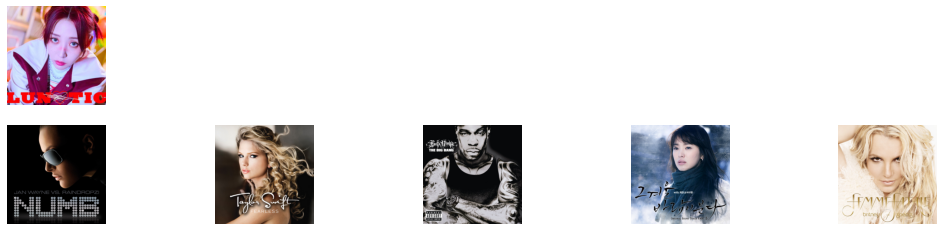

0. 유사도: 2.24	앨범이름: Numb
1. 유사도: 2.45	앨범이름: Fearless
2. 유사도: 2.45	앨범이름: The Big Bang
3. 유사도: 2.45	앨범이름: Baramibunda OST Part 5
4. 유사도: 2.5	앨범이름: Femme Fatale (Deluxe Version)


[4614, 5619, 7292, 13049, 1552]

In [18]:
image_path = 'data/new_image2.jpg'
my_image = Image.open(image_path).resize((300,300))
SENT = 'happy'

recommend_by_object(my_image, sentiment = SENT, n=5)